Дерево решений - наглядное решение того, как стоит поступить в той или иной ситуации, в зависимости 
от складывающихся обстательств.

Деревья решений в обобощенном виде применяются повсеместно, от похода в магазин, до принятия бизнес решений.
Пример будет чуть ниже. Для примера будет использоваться набор данных о выживывших при катастрофе Титанника.

In [1]:
# Подключим библиотеки

import pandas as pd
from sklearn import tree
import matplotlib.pyplot as plt


from sklearn.model_selection import cross_val_score

from sklearn.model_selection import train_test_split 

In [2]:

# Подружаем изначальный набора данных
data = pd.read_csv(r'C:\Тест\Python_Обучение\data\titanic.csv')

# Выбираем обучающий набор, удаляя не нужные столбцы
x = data.drop(["PassengerId", "Survived", "Name", "Ticket", "Cabin"], axis=1)

#преобразуем строковые значения в числовые. Для проведения дальльнейшего анализа.
x = pd.get_dummies(x)

# Все пропуски в обучаеющем наборе заполним медианным значением
x = x.fillna({'Age': x.Age.median()})

# Целевой набор. В данном случае остался ли жив человек.
y = data.Survived

In [3]:
# Разбиваем на тестовые и тренировочные признаки и ответы в соотношении 67 к 33.
# random_state - задает зерно случайности при выборке строк. 
# Если его не задать, то при каждом запуске в тест и train будут попадать разные строки.
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state = 42)


In [4]:



# Задаем параметры для обучения- решающее дерево из библиотеки sklearn.
clf = tree.DecisionTreeClassifier(criterion='entropy')

# Обучаем дерево без настройки глубины
clf.fit(X_train, y_train)

# Находим число правильных ответов на обучающей выборке
Score_train = clf.score(X_train, y_train) 
print("Score_train =", Score_train)

# на тестовой выборке всего 78% правильных результатов
Score_test = clf.score(X_test, y_test) 
print("Score_test = ", Score_test)


Score_train = 1.0
Score_test =  0.7692307692307693


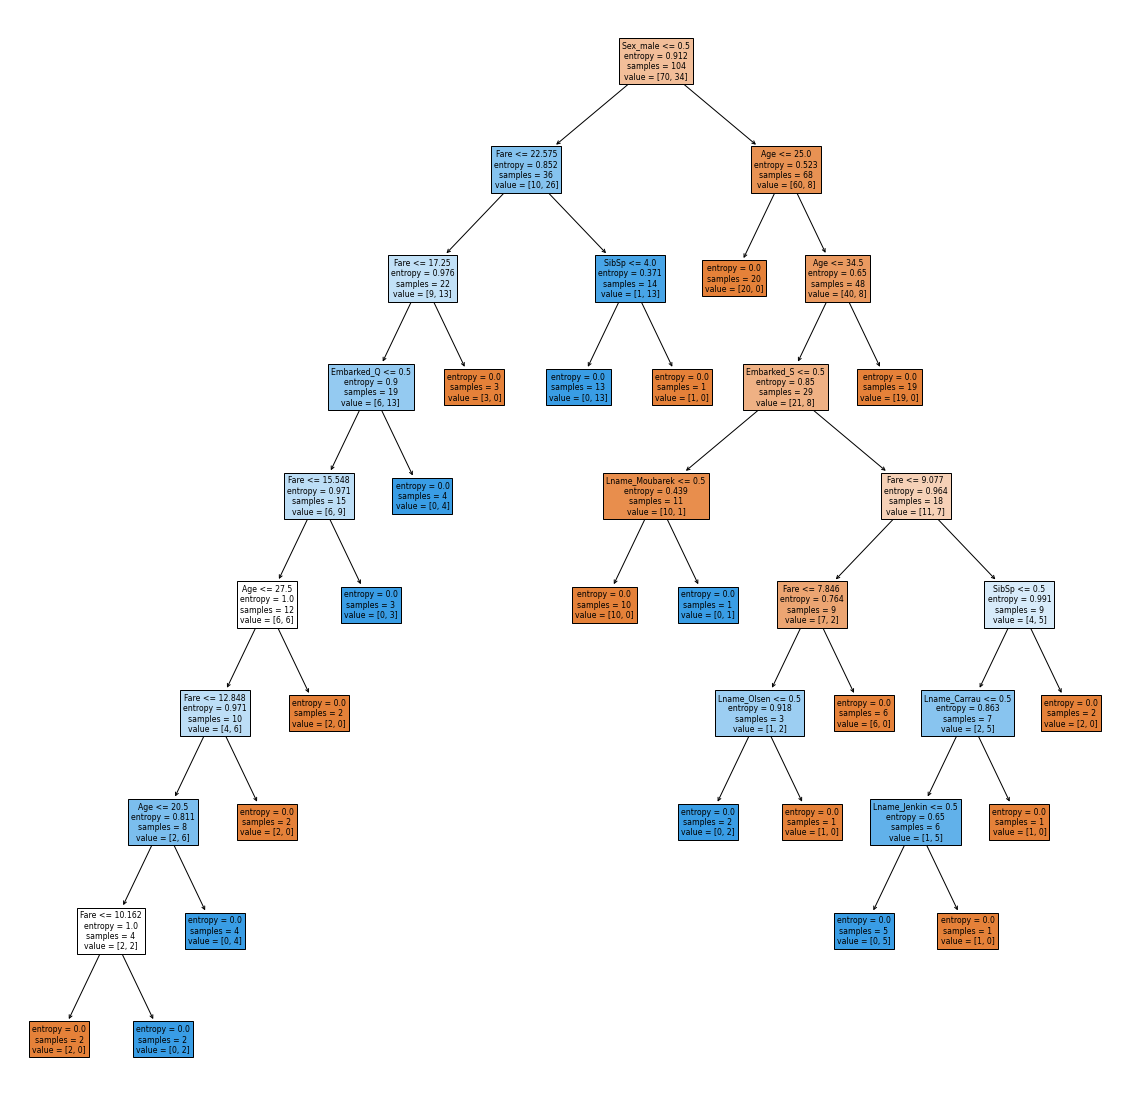

In [5]:

#посмотрим на получившееся дерево

plt.figure(figsize=(20, 20))

tree.plot_tree(clf, feature_names=list(x),
     filled=True)
plt.show()

Самым простым способом снижения переобучения - это уменьшение глубины дерева. Уменьшение числа вопросов физически не дает дереву
уйти в частности.
Остается найти такую высоту дерева, при которой дерево давало бы наилучший резальутат на тестовой выборке, которую оно не 
видело. Это можно сделать простым перебором:

In [6]:


# Переменная, в которую будет записываться степерь проработки(высота)
# и % правильных ответов на тестовой и тренировочной выборке
data_scor = pd.DataFrame()

#цикл по высоте дерева от 1 до 100
for mxd in range(1,100):
    #создаем и обучаем дерево с жестко заданой высотой
    clf = tree.DecisionTreeClassifier(criterion='entropy', max_depth = mxd)
    clf.fit(X_train, y_train)
    
    # Процент правильных ответов на тренировочной и тестовой выборке
    train_score = clf.score(X_train, y_train)
    test_score = clf.score(X_test, y_test)
    
    # Дополнительно проводим кросс-валидацию.
    # Еще одно дополнительное разбиение и тестирование:
    #   * обучение происходит на 4 частях, а на 1 предсказание и тестирование
    #   ** и так по кругу 5 раз
    # в mean_cross_score записываем среднее значение кроссвалидации
    mean_cross_score = cross_val_score(clf, X_train, y_train, cv=5).mean()
    
    # Записываем результаты в массив
    tmp_scr_data = pd.DataFrame({'max_depth': [mxd], 'train_scorer': [train_scorer], 'test_score': [test_score], 'mean_cross_score': [mean_cross_score]})
    data_scor = data_scor.append(tmp_scr_data)
    
#определим глубину дерева, на которой переобучение минимально
#используем для этого значение кроссвалидации
data_scor[data_scor.mean_cross_score == data_scor.mean_cross_score.max()]

#визуализируем уровень вхождения в зависимости от глубины, в зависимости от глубины
plt.plot(data_scor['max_depth'], data_scor['train_scorer'], label='train')
plt.plot(data_scor['max_depth'], data_scor['test_score'], label='test')
plt.plot(data_scor['max_depth'], data_scor['mean_cross_score'], label='mean_cross_score')
plt.ylabel('score')
plt.xlabel('depth')
plt.legend()
plt.show()

NameError: name 'train_scorer' is not defined

In [ ]:
#посмотрим на получившееся дерево

plt.figure(figsize=(20, 20))

tree.plot_tree(clf, feature_names=list(x),
     filled=True)
plt.show()

Дополнительные параметры оценки качества дерева
Помимо процента правильных ответов в выборке,  имеется ряд показателей которые способны определить оценку качества дерева:
TP - true positive (правильное предсказание срабатывания)
FP - false positive (ложное срабатывание)
FN - false negative (должно было сработать, но нет)
Precission = TP / (TP + FP) - точность (нахождение ответа не переплачивая лишними срабатываниями) важна, если мало признаков
Recall = TP / (TP + FN) - полнота (сколько процентов среди всех экспериментов было найдено) - важно если много ресурсов
показатели независимы, необходимо выбирать нужный в зависимости от числа признаков.

Комбинированная средняя метрика F = 2 * (precision * recall) / (precision + recall)
Указанные выше показатели можно найти следующим образом:

In [ ]:
from sklearn.metrics import precision_score


predictions = clf.predict(X_test)
data_scor = pd.DataFrame({'predictions': predictions, 'Y': y_test})
tp = data_scor[data_scor.predictions == data_scor.Y].shape[0]   # Нахождение True Positive
fp = data_scor[data_scor.predictions != data_scor.Y].shape[0]   # Нахождение False Negative
precision = tp / (tp + fp)                                      # Нахождение точности

# Точность, можно также найти в одну строку одной строкой:
precision1 = precision_score(y_test, predictions, average='micro') 

print('precision = ', precision)
print('precision1 = ', precision1)

Другой пример, когда нам важно спасти с Титаника как можно больше людей, не смотря на затраты ресурсов, даже если вероятность 
выжить человека низка.
Отсечка для определения класса выжил/погиб = 0,5
Мы можем получить на выходе дерева не класс, а вероятность и отобрать то число людей, с такой вероятностью, которую мы сами 
захотим:

Для того чтобы каждый раз не писать подобные циклы в библеотеке sklearn есть замечательное решение которое позволяет находить
наиболее опитимальное решение -  GridSearchCV.
Тезисно GridSearchCV находит наиболее оптимальные параметры для каждого алгоримта Sklearn.


In [7]:
from sklearn.model_selection import GridSearchCV
clf = tree.DecisionTreeClassifier()

#параметры, которые будем подбирать
#список параметров можно взять из описания объема clf
parameters = {'criterion': ['gini', 'entropy'], 'max_depth': range(1,20), 'min_samples_split': range(2,50, 2), 'min_samples_leaf': range(1,20)}

#cv - групп для кросс-валидации
grid_search_cv_clf = GridSearchCV(clf, parameters, cv=5, n_jobs=-1)

#обучение N деревьев, где N - число сочетаний parameters
grid_search_cv_clf.fit(X_train, y_train)

#просмотр параметров лучшего дерева
grid_search_cv_clf.best_params_ # {'criterion': 'gini', 'max_depth': 6, 'min_samples_leaf': 7, 'min_samples_split': 4}

#лучшее дерево
best_clf = grid_search_cv_clf.best_estimator_
best_clf.score(X_test, y_test)

0.7884615384615384

In [8]:
import numpy as np

prediction_prob = best_clf.predict_proba(X_test)

#считаем выжившими людей, у которых вероятность выжить > 0.2 (вместо 0,5 по умолчанию)
y_pred = np.where(prediction_prob[:, 1] > 0.2, 1, 0)

print(y_pred)


[0 1 1 1 1 1 0 1 1 0 1 1 1 0 0 0 1 1 0 0 1 0 0 1 1 0 1 1 0 0 1 1 1 0 1 0 0
 1 1 1 0 1 0 1 0 1 0 0 1 0 0 0]
